Refer to README. 
create new notebooks when progressing and always update the project file.

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

import matplotlib.dates as mdates
from statsmodels.tsa.stattools import coint
from sklearn.linear_model import LinearRegression

In [2]:
all_mid_price = pd.read_csv("mid_price.csv",index_col = "date")
all_mid_price.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,KO,MMM
date,,,,,,,,,,
2018-09-04 09:30:00,228.132627,106.147767,341.790009,138.416835,47.853729,118.841111,111.821785,69.902721,44.578301,210.868002
2018-09-04 09:30:30,228.190561,106.234375,341.553699,138.664641,47.795386,118.680314,111.847000,69.571233,44.565594,210.440002
2018-09-04 09:31:00,228.555690,106.226999,341.797000,138.363464,47.843667,118.720001,111.813605,69.682065,44.545926,210.305000
2018-09-04 09:31:30,228.721917,106.233500,341.558073,138.011875,47.874854,118.730293,111.698751,69.737632,44.541667,209.980519
2018-09-04 09:32:00,228.787086,106.091999,341.289111,137.952408,47.889313,118.784318,111.588810,69.745909,44.521532,209.765501


In [3]:
def update_position(xLastPosition,yLastPosition,signal,openBound,closeBound,stopBound,positionVolume):
    xNewPosition, yNewPosition = xLastPosition,yLastPosition
    # Long spread x-y
    if (yLastPosition>=0 and signal>=openBound and signal<=stopBound):
        xNewPosition, yNewPosition = positionVolume, -1

    # Short spread 
    elif(yLastPosition<=0 and signal<=-openBound and signal>=-stopBound):
        xNewPosition, yNewPosition = -positionVolume, 1
    
    # Close long spread
    elif(yLastPosition>0 and (signal<-stopBound or signal>-closeBound)):
        xNewPosition, yNewPosition = 0, 0
    
    # Close short spread
    elif(yLastPosition<0 and (signal>stopBound or signal<closeBound)):
        xNewPosition, yNewPosition = 0, 0
    
    # Adjust long spread
    elif(yLastPosition<0 and ~(signal>stopBound or signal<closeBound)):
        xNewPosition, yNewPosition = positionVolume, -1
    
    # Adjust short spread
    elif(yLastPosition>0 and ~(signal<-stopBound or signal>-closeBound)):
        xNewPosition, yNewPosition = -positionVolume, 1
        
    return xNewPosition,yNewPosition


In [4]:
def plot_spread(df, tick1, tick2, index, op, stop):
  
    px1 = df[tick1].iloc[index]/df[tick1].iloc[index[0]]
    px2 = df[tick2].iloc[index]/df[tick2].iloc[index[0]]
    
    px1=np.log(px1)
    px2=np.log(px2)
    
    sns.set(style='white')
    
    # Set plotting figure
    fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]})

    # Plot the return plot
    sns.lineplot(data=[px1, px2], linewidth=1.2, ax=ax[0])
    ax[0].legend(loc='upper left')
    
    # Calculate the spread and other thresholds
    spread = df[tick1].iloc[index] - df[tick2].iloc[index]
    #spread = px1 - px2

    mean = spread.mean()
    sell_th     = mean + op
    sell_stop   = mean + stop
    buy_th      = mean - op
    buy_stop    = mean - stop
    
    # Plot the 2nd subplot
    sns.lineplot(data=spread, color='#85929E', ax=ax[1], linewidth=1.2)
    ax[1].axhline(sell_th,   color='b', ls='--',  label='sell_threshold',linewidth=2)
    ax[1].axhline(buy_th,    color='r', ls='--', label='buy_threshold',linewidth=2)
    ax[1].axhline(sell_stop, color='g', ls='--',  label='sell_stop',linewidth=1)
    ax[1].axhline(buy_stop,  color='y', ls='--',  label='buy_stop',linewidth=1)
    ax[1].fill_between(idx, sell_th, buy_th, facecolors='r',alpha=0.4)
    ax[1].legend(loc='upper left', labels=['Spread', 'sell_th', 'buy_th', 'sell_stop', 'buy_stop'], prop={'size':8.5})
    plt.show()

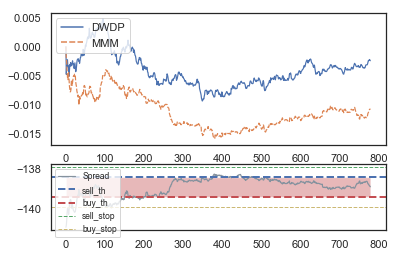

In [5]:
one="DWDP"
two="MMM"
idx = range(len(all_mid_price))
temp=all_mid_price.copy()
temp=temp.reset_index(drop=True)
plot_spread(temp, one, two, idx, .5, 1)

In [6]:
def back_test(all_price_data,tick1,tick2,debug=False):
    price_1=all_price_data[tick1][0]
    price_2=all_price_data[tick2][0]
    if(price_1>=price_2):
        backtest_data=all_price_data[[tick1,tick2]].copy()
    else:
        backtest_data=all_price_data[[tick2,tick1]].copy()
    backtest_data=pd.DataFrame(backtest_data)
    backtest_data.columns=['price_y','price_x']
    backtest_data['ln_x']=np.log(backtest_data['price_x'])
    backtest_data['ln_y']=np.log(backtest_data['price_y'])
    
    # model paramters hardcoded, RECODE THIS
    lookback=100
    n=lookback 
    open_const=2
    stop_const=3
    close_const=1
    
    fee=0
    backtest_data['residual']=0
    backtest_data['std']=0
    backtest_data['position_x']=0
    backtest_data['position_y']=0
    backtest_data['profit_x']=0
    backtest_data['profit_y']=0
    backtest_data['coef']=0

    for i in range(n+1,len(backtest_data)):
        
        # Rolling Linear Regression to get signal
        X=np.array(backtest_data['ln_x'][i-n:i-1]).reshape(-1,1)
        Y=np.array(backtest_data['ln_y'][i-n:i-1])
        model=LinearRegression().fit(X,Y)
        coef=model.coef_[0]        
        residual=Y-model.predict(X)
        std=np.std(residual)
        next_X=np.array(backtest_data['ln_x'][i]).reshape(-1,1)
        next_Y=np.array(backtest_data['ln_y'][i])
        Y_hat=model.predict(next_X)
        next_residual=next_Y-Y_hat
        backtest_data['residual'].iloc[i]=next_residual
        backtest_data['std'].iloc[i]=std
        
        # Use regression residual as signal to trade
        xNewPosition,yNewPosition = update_position(xLastPosition = backtest_data['position_x'].iloc[i-1],
                                                    yLastPosition = backtest_data['position_y'].iloc[i-1],
                                                    signal = backtest_data['residual'].iloc[i],
                                                    openBound = open_const*backtest_data['std'].iloc[i],
                                                    closeBound = close_const*backtest_data['std'].iloc[i],
                                                    stopBound = stop_const*backtest_data['std'].iloc[i],
                                                    positionVolume = abs(coef))
        
        backtest_data['position_x'].iloc[i], backtest_data['position_y'].iloc[i] = xNewPosition,yNewPosition

        backtest_data['profit_x'].iloc[i]=backtest_data['position_x'].iloc[i-1]*(backtest_data['price_x'].iloc[i]/backtest_data['price_x'].iloc[i-1]-1)-abs(backtest_data['position_x'].iloc[i-1]-backtest_data['position_x'].iloc[i-2])*fee  #profit_x
        backtest_data['profit_y'].iloc[i]=backtest_data['position_y'].iloc[i-1]*(backtest_data['price_y'].iloc[i]/backtest_data['price_y'].iloc[i-1]-1)-abs(backtest_data['position_y'].iloc[i-1]-backtest_data['position_y'].iloc[i-2])*fee  #profit_x
    
    #print trading log for debugging 
    if (debug):
        backtest_data.to_csv("backtest_trading_log.csv")
    
    #calculate profit
    backtest_data['total_profit']=backtest_data['profit_x']+backtest_data['profit_y']
    backtest_data['cum_profit']=np.cumsum(backtest_data['total_profit'])
    
    result=pd.DataFrame([backtest_data['cum_profit'][-1]], columns=['return'])
    result['open']=open_const
    result['close']=close_const
    result['stop']=stop_const
    result['lookback']=n
    result['tick_1']=tick1
    result['tick_2']=tick2
    
    plt.plot(backtest_data['cum_profit'].reset_index(drop=True))
    plt.title('Cumulative Return vs Time')
    plt.show()
    return result

C:\Users\kevin\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


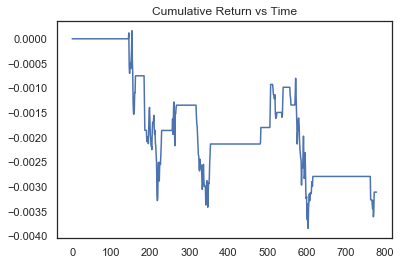

,return,open,close,stop,lookback,tick_1,tick_2
0,-0.003111,2,1,3,100,AXP,BA


In [7]:
back_test(all_mid_price,"AXP","BA",True)